**1. [LO1, LO2, LO3, LO4] Anda adalah seorang data scientist di sebuah lembaga riset yang memiliki tugas untuk membuat model klasifikasi multiclass text. Namun anda tidak memiliki data sehingga untuk membangun model klasifikasi text, anda perlu untuk melakukan beberapa hal berikut:**

# INSTALL LIBRARY

In [ ]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.1 MB/s eta 0:00:0000:01


# IMPORT ALL LIBRARY

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import Counter

import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud

import torch
from torch import nn
from transformers import BertModel, AdamW
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# A. SCRAPPING NEWS

a. [5%] Mengumpulkan data teks berita dengan menggunakan metode web scrapping minimal total 100 data teks berita yang berasal dari media digital seperti liputan 6, detik.com dan lain-lain dengan kategori berita berita olahraga non sepak bola, berita liga Inggris, liga Indonesia, liga spanyol dan liga Italia . Data ini harus berasal minimal dari 2 media yang berbeda dan anda juga perlu melakukan pelabelan.

In [ ]:
# Definisikan kategori dan sumber media secara fleksibel
categories = {
    "Liputan6": [
        {"url": "https://www.liputan6.com/bola/sports", "label": "Olahraga Non Sepak Bola"},
        {"url": "https://www.liputan6.com/bola/liga-inggris", "label": "Liga Inggris"},
        {"url": "https://www.liputan6.com/bola/liga-nasional", "label": "Liga Indonesia"},
        {"url": "https://www.liputan6.com/bola/liga-spanyol", "label": "Liga Spanyol"},
        {"url": "https://www.liputan6.com/bola/liga-italia", "label": "Liga Italia"},
    ],
    "Detik": [
        {"url": "https://sport.detik.com/sport-lain", "label": "Olahraga Non Sepak Bola"},
        {"url": "https://sport.detik.com/sepakbola/liga-inggris", "label": "Liga Inggris"},
        {"url": "https://sport.detik.com/sepakbola/liga-indonesia", "label": "Liga Indonesia"},
        {"url": "https://sport.detik.com/sepakbola/liga-spanyol", "label": "Liga Spanyol"},
        {"url": "https://sport.detik.com/sepakbola/liga-italia", "label": "Liga Italia"},
    ]
}

In [ ]:
# Header untuk HTTP request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}

In [ ]:
# Fungsi untuk mengambil link artikel dari satu halaman
def get_links(page_url, media):
    response = requests.get(page_url, headers=headers)
    soup = BeautifulSoup(response.content, "html.parser")

    if media == "Liputan6":
        return [a["href"] for a in soup.find_all("a", class_="ui--a articles--iridescent-list--text-item__title-link") if "href" in a.attrs]
    elif media == "Detik":
        return [a["href"] for a in soup.find_all("a", class_="media__link") if "href" in a.attrs]

In [ ]:
# Fungsi untuk scrape konten artikel
def scrape(link, media):
    try:
        response = requests.get(link, headers=headers)
        soup = BeautifulSoup(response.content, "html.parser")

        if media == "Liputan6":
            title_tag = soup.find("h1", class_="read-page--header--title entry-title")
            content_container = soup.find_all("div", class_="article-content-body__item-content")
        elif media == "Detik":
            title_tag = soup.find("h1", class_="detail__title")
            content_container = soup.find_all("div", class_="detail__body-text itp_bodycontent")

        # Judul
        title = title_tag.text.strip() if title_tag else "Judul tidak ditemukan"

        # Konten artikel
        paragraphs = [
            p.text.strip()
            for div in content_container
            for p in div.find_all("p") if p.text.strip()
        ]
        content = "\n".join(paragraphs)

        return title, content
    except Exception as e:
        print(f"Error scraping article: {e}")
        return None, None

In [ ]:
# Proses scraping utama
def scrape_articles(media_name, categories, max_articles=20):
    all_data = []
    for category in categories:
        url = category["url"]
        label = category["label"]
        scraped_links = set()  # Untuk menghindari duplikasi link
        page = 1

        print(f"Scraping kategori: {label} dari {media_name}...")
        while len(scraped_links) < max_articles:
            page_url = f"{url}?page={page}"
            article_links = get_links(page_url, media_name)

            if not article_links:
                break  # Jika tidak ada artikel lagi, hentikan

            for link in article_links:
                if len(scraped_links) >= max_articles:
                    break

                if link not in scraped_links:
                    title, content = scrape(link, media_name)
                    if title and content:
                        all_data.append({"Teks": content, "Media": media_name, "Label": label})
                        scraped_links.add(link)
            page += 1
    return all_data

In [ ]:
# Scrape dari Liputan6 dan Detik
liputan6_data = scrape_articles("Liputan6", categories["Liputan6"])
detik_data = scrape_articles("Detik", categories["Detik"])

Scraping kategori: Olahraga Non Sepak Bola dari Liputan6...
Scraping kategori: Liga Inggris dari Liputan6...
Scraping kategori: Liga Indonesia dari Liputan6...
Scraping kategori: Liga Spanyol dari Liputan6...
Scraping kategori: Liga Italia dari Liputan6...
Scraping kategori: Olahraga Non Sepak Bola dari Detik...
Scraping kategori: Liga Inggris dari Detik...
Scraping kategori: Liga Indonesia dari Detik...
Scraping kategori: Liga Spanyol dari Detik...
Scraping kategori: Liga Italia dari Detik...


In [ ]:
# Ubah list hasil scraping ke DataFrame
liputan6_df = pd.DataFrame(liputan6_data)
detik_df = pd.DataFrame(detik_data)

## Menampilkan beberapa baris pertama dari masing-masing DataFrame

In [ ]:
print("Data dari Liputan6:")
liputan6_df.head()  # Menampilkan 5 baris pertama

Data dari Liputan6:


,Teks,Media,Label
0,"Liputan6.com, Jakarta - Jakarta Livin Mandiri ...",Liputan6,Olahraga Non Sepak Bola
1,"Liputan6.com, Jakarta - Putri Kusuma Wardani m...",Liputan6,Olahraga Non Sepak Bola
2,"Liputan6.com, Jakarta Ganda putra bulu tangkis...",Liputan6,Olahraga Non Sepak Bola
3,"Liputan6.com, Jakarta - Febriana Dwipuji Kusum...",Liputan6,Olahraga Non Sepak Bola
4,"Liputan6.com, Jakarta Gregoria Mariska Tunjung...",Liputan6,Olahraga Non Sepak Bola


In [ ]:
print("\nData dari Detik:")
detik_df.head()  # Menampilkan 5 baris pertama


Data dari Detik:


,Teks,Media,Label
0,Aryna Sabalenka melaju ke final grand slam Aus...,Detik,Olahraga Non Sepak Bola
1,Hendra Setiawan/Mohammad Ahsan akhirnya benar-...,Detik,Olahraga Non Sepak Bola
2,Jonatan Christie menjawab harapan PBSI yang me...,Detik,Olahraga Non Sepak Bola
3,Jonatan Christie sukses memenangi laga pertama...,Detik,Olahraga Non Sepak Bola
4,Gregoria Mariska Tunjung mulus ke babak 16 bes...,Detik,Olahraga Non Sepak Bola


In [ ]:
# gabungkan data dan simpan
all_data = liputan6_data + detik_data
df = pd.DataFrame(all_data)
print("Scraping selesai! Dataset tersimpan di DataFrame.")

Scraping selesai! Dataset tersimpan di DataFrame.


In [ ]:
df.head()

,Teks,Media,Label
0,"Liputan6.com, Jakarta - Jakarta Livin Mandiri ...",Liputan6,Olahraga Non Sepak Bola
1,"Liputan6.com, Jakarta - Putri Kusuma Wardani m...",Liputan6,Olahraga Non Sepak Bola
2,"Liputan6.com, Jakarta Ganda putra bulu tangkis...",Liputan6,Olahraga Non Sepak Bola
3,"Liputan6.com, Jakarta - Febriana Dwipuji Kusum...",Liputan6,Olahraga Non Sepak Bola
4,"Liputan6.com, Jakarta Gregoria Mariska Tunjung...",Liputan6,Olahraga Non Sepak Bola


# B. DATA PREPROCESSING

b.
[5%] Melakukan text preprocessing seperti cleansing, tokenization, filtering dan anda dapat menambahkan stemming atau lemmatization jika diperlukan.

## HAPUS "Liputan6.com, Jakarta - "

In [ ]:
# Tampilkan data yang hanya berasal dari Liputan6
print("Data yang hanya berasal dari Liputan6:")
df[df["Media"] == "Liputan6"].head()

Data yang hanya berasal dari Liputan6:


,Teks,Media,Label
0,"Liputan6.com, Jakarta - Jakarta Livin Mandiri ...",Liputan6,Olahraga Non Sepak Bola
1,"Liputan6.com, Jakarta - Putri Kusuma Wardani m...",Liputan6,Olahraga Non Sepak Bola
2,"Liputan6.com, Jakarta Ganda putra bulu tangkis...",Liputan6,Olahraga Non Sepak Bola
3,"Liputan6.com, Jakarta - Febriana Dwipuji Kusum...",Liputan6,Olahraga Non Sepak Bola
4,"Liputan6.com, Jakarta Gregoria Mariska Tunjung...",Liputan6,Olahraga Non Sepak Bola


In [ ]:
# Menampilkan semua baris
pd.set_option('display.max_rows', None)

# Menampilkan hasil
df[df["Media"] == "Liputan6"]['Teks'].str[:24]

0     Liputan6.com, Jakarta - 
1     Liputan6.com, Jakarta - 
2     Liputan6.com, Jakarta Ga
3     Liputan6.com, Jakarta - 
4     Liputan6.com, Jakarta Gr
5     Liputan6.com, Jakarta Du
6     Liputan6.com, Jakarta- T
7     Liputan6.com, Jakarta Tu
8     Liputan6.com, Jakarta - 
9     Liputan6.com, Jakarta Tu
10    Liputan6.com, Jakarta- T
11    Liputan6.com, Jakarta Tu
12    Liputan6.com, Jakarta Pe
13    Liputan6.com, Jakarta- T
14    Liputan6.com, Jakarta- P
15    Liputan6.com, Jakarta - 
16    Liputan6.com, Jakarta - 
17    Liputan6.com, Jakarta Tu
18    Liputan6.com, Jakarta Tu
19    Liputan6.com, Jakarta Tu
20    Liputan6.com, Jakarta- N
21    Liputan6.com, Jakarta- M
22    Liputan6.com, Jakarta Ma
23    Liputan6.com, Jakarta Be
24    Liputan6.com, Jakarta Kr
25    Liputan6.com, Jakarta - 
26    Liputan6.com, Jakarta Ma
27    Liputan6.com, Jakarta Ch
28    Liputan6.com, Jakarta- S
29    Liputan6.com, Jakarta Ma
30    Liputan6.com, Jakarta- M
31    Liputan6.com, Jakarta- A
32    Li

In [ ]:
# Filter baris dengan Media "Liputan6" dan terapkan penghapusan teks menggunakan regex
df.loc[df["Media"] == "Liputan6", "Teks"] = df.loc[df["Media"] == "Liputan6", "Teks"].str.replace(r"Liputan6.com, Jakarta[- ]*", "", regex=True)

# Menampilkan hasil untuk verifikasi
print(df[df["Media"] == "Liputan6"]["Teks"].head())

0    Jakarta Livin Mandiri akan menjadi tuan rumah ...
1    Putri Kusuma Wardani menjadi wakil tuan rumah ...
2    Ganda putra bulu tangkis senior Indonesia, Moh...
3    Febriana Dwipuji Kusuma/Amallia Cahaya Pratiwi...
4    Gregoria Mariska Tunjung bermain dalam kondisi...
Name: Teks, dtype: object


In [ ]:
df[df["Media"] == "Liputan6"].head()

,Teks,Media,Label
0,Jakarta Livin Mandiri akan menjadi tuan rumah ...,Liputan6,Olahraga Non Sepak Bola
1,Putri Kusuma Wardani menjadi wakil tuan rumah ...,Liputan6,Olahraga Non Sepak Bola
2,"Ganda putra bulu tangkis senior Indonesia, Moh...",Liputan6,Olahraga Non Sepak Bola
3,Febriana Dwipuji Kusuma/Amallia Cahaya Pratiwi...,Liputan6,Olahraga Non Sepak Bola
4,Gregoria Mariska Tunjung bermain dalam kondisi...,Liputan6,Olahraga Non Sepak Bola


In [ ]:
# simpen df ke file csv
path_df = "news_sport_scrapping.csv"

df.to_csv(path_df, index=False)

## EXPLORATION

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Teks    200 non-null    object
 1   Media   200 non-null    object
 2   Label   200 non-null    object
dtypes: object(3)
memory usage: 4.8+ KB


In [ ]:
df.shape

(200, 3)

In [ ]:
df['Media'].value_counts()

Media
Liputan6    100
Detik       100
Name: count, dtype: int64

In [ ]:
df['Label'].value_counts()

Label
Olahraga Non Sepak Bola    40
Liga Inggris               40
Liga Indonesia             40
Liga Spanyol               40
Liga Italia                40
Name: count, dtype: int64

In [ ]:
df['Teks'].sample(5, random_state=42)

95     Juventus dan AC Milan bentrok pada semifinal S...
15     Putri Kusuma Wardani melangkah ke babak 16 bes...
30     Manchester United pernah punya pengalaman pahi...
158    Liga 1 memainkan dua pertandingan pada hari in...
128    Kabar kurang sedap dari Ruud van Nistelrooy. K...
Name: Teks, dtype: object

In [ ]:
missing_values = df.isnull().sum()
print("Jumlah nilai yang hilang di setiap kolom:")
print(missing_values)

Jumlah nilai yang hilang di setiap kolom:
Teks     0
Media    0
Label    0
dtype: int64


In [ ]:
duplicates = df.duplicated().sum()
print(f"Jumlah entri duplikat: {duplicates}")

Jumlah entri duplikat: 0


In [ ]:
teks_length_stats = df['Teks'].str.len().describe()
print("Distribusi panjang teks konten (dalam karakter):")
print(teks_length_stats)

Distribusi panjang teks konten (dalam karakter):
count     200.000000
mean     2188.765000
std       825.615987
min       916.000000
25%      1622.750000
50%      2042.000000
75%      2516.250000
max      6099.000000
Name: Teks, dtype: float64


In [ ]:
# Filter komentar dengan panjang kurang dari 3 karakter
short_teks = df[df['Teks'].str.len() < 10]
print("Konten dengan panjang kurang dari 5 karakter:")
print(short_teks)

Konten dengan panjang kurang dari 5 karakter:
Empty DataFrame
Columns: [Teks, Media, Label]
Index: []


## DATA CLEANING

In [ ]:
def cleanse_text(text):
    text = text.lower()  # mengubah teks menjadi lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # menghapus karakter non-huruf dan angka
    text = re.sub(r'[^\w\s]', '', text)  # menghapus simbol dan tanda baca
    text = re.sub(r'\s+', ' ', text).strip()  # menghapus spasi berlebih
    return text

df['Teks'] = df['Teks'].apply(cleanse_text)

CEK APAKAH MASIH ADA KARAKTER ANEH

In [ ]:
# Menggabungkan semua teks yang sudah dibersihkan
all_cleaned_text = ' '.join(df['Teks'])

In [ ]:
# mendapatkan karakter unik
unique_chars = set(all_cleaned_text)
print("Karakter Unik dalam Data yang Sudah Dibersihkan:")
print(unique_chars)

Karakter Unik dalam Data yang Sudah Dibersihkan:
{'v', ' ', 'a', 'j', 'm', 'k', 'p', 'b', 's', 'h', 'f', 'w', 'i', 'l', 'n', 'r', 'd', 'e', 'q', 'u', 'z', 'o', 'c', 'x', 'y', 'g', 't'}


## SPLITTING

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

print(len(df_train), len(df_val), len(df_test))

160 20 20


**Alasan tidak melakukan penghapusan stopwords :**


Dalam konteks menggunakan **BERT**, sebenarnya **tidak perlu menghapus stopwords**. Karena BERT itu didesain untuk memahami hubungan antar-token (kata), termasuk stopwords seperti "di", "ke", atau "dan". Stopwords ini ternyata bisa memberikan konteks penting dalam sebuah kalimat, apalagi kalau kita bicara soal hubungan antar kata.


BERT juga menggunakan **WordPiece Tokenization**, yang memecah kata menjadi subword. Jadi, kata-kata sederhana seperti stopwords tetap dipertimbangkan, karena BERT memandang teks secara utuh untuk memahami makna kalimat.

**Alasan tidak melakukan lemamtization :**

Karena BERT itu sudah pintar memahami konteks dari setiap kata dalam kalimat, bahkan tanpa harus kita ubah ke bentuk dasarnya (lemma).
Walaupun kata yang sama dipakai dalam fungsi yang berbeda (kata kerja di kalimat pertama, kata benda di kalimat kedua), BERT tetap bisa memahami konteksnya tanpa harus diubah dulu ke bentuk dasar.

BERT juga menggunakan tokenisasi subword, jadi dia nggak hanya melihat kata secara utuh.

Lemmatization kadang malah bisa bikin informasi penting hilang. Misalnya, kata "bermain" kalau diubah ke "main," nuansa aktivitasnya bisa jadi hilang. Sementara itu, BERT sebenarnya sudah cukup pintar untuk menangkap makna tanpa kita ubah apa-apa.

## TOKENIZATION MENGGUNAKAN BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Top 50 kata dengan frekuensi tertinggi:
di: 1252
yang: 806
dan: 744
dengan: 541
ini: 534
dari: 466
itu: 358
untuk: 351
ke: 337
pada: 334
indonesia: 313
saya: 283
dalam: 282
juga: 275
gol: 266
akan: 249
pemain: 247
vs: 239
dia: 211
liga: 206
tidak: 203
bisa: 193
milan: 190
sudah: 177
laga: 175
mu: 174
united: 172
kami: 170
menjadi: 168
tim: 165
jadi: 162
mereka: 161
advertisement: 160
setelah: 157
saat: 150
pelatih: 150
tahun: 148
lebih: 146
sebagai: 145
juventus: 143
musim: 142
bola: 141
menit: 137
dua: 135
madrid: 135
poin: 129
manchester: 128
pertandingan: 126
satu: 123
masih: 121


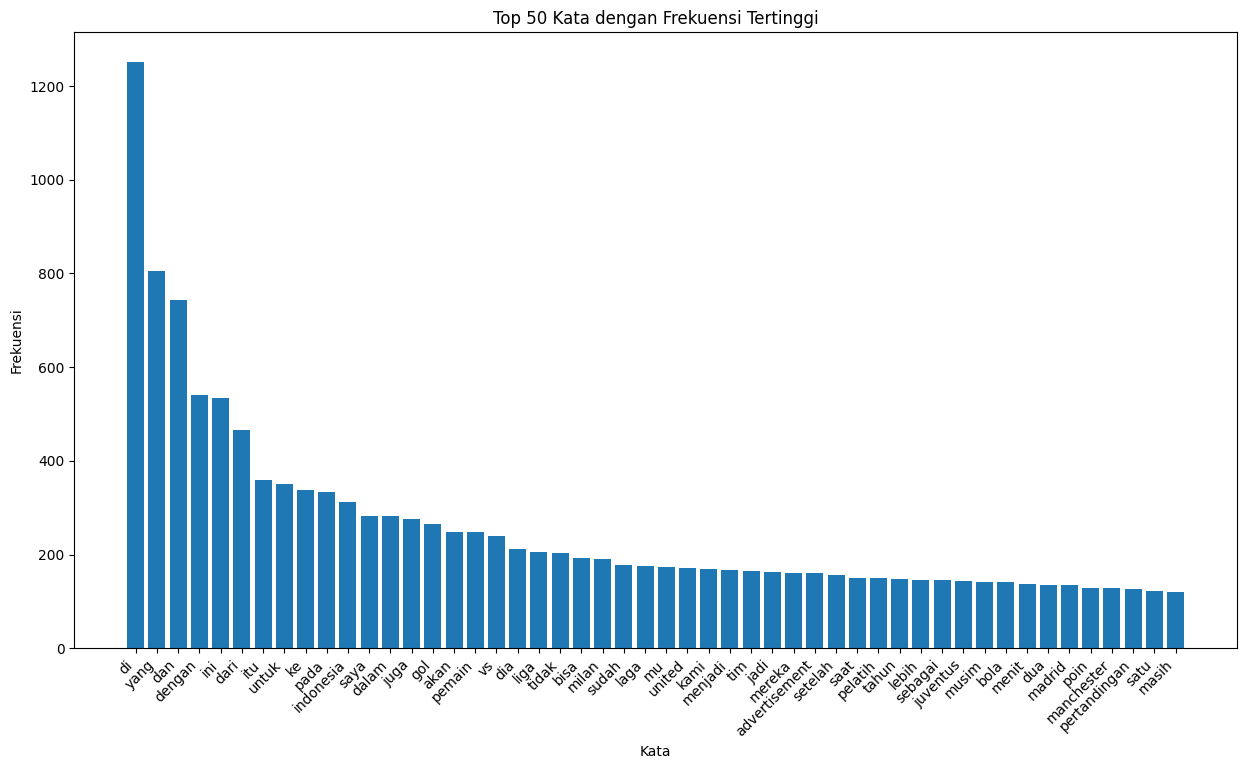

In [ ]:
# Gabungkan semua teks yang sudah diproses menjadi satu string
all_text = ' '.join(df_train['Teks'])

# Tokenisasi: Memisahkan kata-kata
words = all_text.split()

# Hitung frekuensi kata
word_counts = Counter(words)

# Ambil 50 kata dengan frekuensi tertinggi
top_50_words = word_counts.most_common(50)

# Tampilkan hasil
print("Top 50 kata dengan frekuensi tertinggi:")
for word, freq in top_50_words:
    print(f"{word}: {freq}")

# Visualisasi dengan bar chart
words, frequencies = zip(*top_50_words)
plt.figure(figsize=(15, 8))
plt.bar(words, frequencies)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Kata")
plt.ylabel("Frekuensi")
plt.title("Top 50 Kata dengan Frekuensi Tertinggi")
plt.show()

# C. MODEL KLASIFIKASI DENGAN LARGE LANGUAGE MODEL (LLM)

c. [20%] Bangunlah model klasifikasi dengan menggunakan Large Language Model (LLM), anda dapat menggunakan pretrained model yang akan anda jelaskan pada penjelasan dengan melakukan minimal 2 hyperparameter tuning. Dalam melakukan pemodelan anda diminta untuk membangun 2 model dan membandingkan hasilnya. Model pertama adalah model LLM 1 stage, dimana anda langsung melakukan klasifikasi dengan menggunakan 5 label langsung dalam 1 model. Model kedua adalah model LLM 2 stage, dimana stage pertama anda melakukan klasifikasi dengan 2 kelas, yaitu berita olah raga sepak bola dan berita olahraga non sepak bola, kemudian untuk berita olahraga sepakbola anda melakukan klasifikasi kembali ke kelas yang lebih spesifik ke kelas berita liga Inggris, liga Indonesia, liga spanyol dan liga Italia.

## MODEL 1-STAGE

In [ ]:
# Encode labels
labels_1stage = {'Olahraga Non Sepak Bola': 0, 'Liga Inggris': 1, 'Liga Indonesia': 2, 'Liga Spanyol': 3, 'Liga Italia': 4}

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels_1stage[label] for label in df['Label']]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['Teks']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

### MODEL 1-STAGE PERTAMA

**Model Arsitektur**  
- **Backbone:** IndoBERT dari `indobenchmark/indobert-base-p2` untuk ekstraksi fitur.  
- **Dropout Layer:** Probabilitas dropout sebesar 0.5 untuk mencegah overfitting.  
- **Classifier:** Fully connected layer (`nn.Linear`) dengan output 5 neuron (sesuai jumlah kelas).  

Detail forward pass:
- **Input:** `input_ids` dan `attention_mask` dari tokenizer.  
- **Output BERT:** Representasi `pooled_output` dari lapisan terakhir BERT.  
- **Dropout:** Output dari BERT dilewatkan melalui lapisan dropout.  
- **Classifier:** Output dropout diteruskan ke layer linear untuk prediksi probabilitas kelas.

---

**Hyperparameter Training**  
- **Optimizer:** Adam  
- **Learning Rate:** \(1 \times 10^{-6}\)  
- **Loss Function:** CrossEntropyLoss  
- **Batch Size:** 2  
- **Epochs:** 15  

In [ ]:
# Define BertClassifier class
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('indobenchmark/indobert-base-p2')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, 5)  # Output: 5 classes

    def forward(self, input_ids, attention_mask):
        # Ambil keluaran dari model BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        pooled_output = self.dropout(outputs[1])
        return self.classifier(pooled_output)

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    # List untuk menyimpan hasil
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        # Training phase
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        # Hitung rata-rata loss dan akurasi untuk training
        avg_train_loss = total_loss_train / len(train_data)
        avg_train_accuracy = total_acc_train / len(train_data)

        # Validasi phase
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        # Hitung rata-rata loss dan akurasi untuk validasi
        avg_val_loss = total_loss_val / len(val_data)
        avg_val_accuracy = total_acc_val / len(val_data)

        # Simpan hasil ke dalam list
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        # Cetak hasil setiap epoch
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {avg_train_loss:.3f} \
            | Train Accuracy: {avg_train_accuracy:.3f} \
            | Val Loss: {avg_val_loss:.3f} \
            | Val Accuracy: {avg_val_accuracy:.3f}'
        )
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
EPOCHS_1 = 15
model_1 = BertClassifier()
LR_1 = 1e-6

model_1stage_first, _, _, _, _ = train(model_1, df_train, df_val, LR_1, EPOCHS_1)

100%|██████████| 80/80 [00:18<00:00,  4.37it/s]


Epochs: 1 | Train Loss: 0.830             | Train Accuracy: 0.194             | Val Loss: 0.814             | Val Accuracy: 0.150


100%|██████████| 80/80 [00:18<00:00,  4.21it/s]


Epochs: 2 | Train Loss: 0.791             | Train Accuracy: 0.250             | Val Loss: 0.772             | Val Accuracy: 0.350


100%|██████████| 80/80 [00:19<00:00,  4.12it/s]


Epochs: 3 | Train Loss: 0.750             | Train Accuracy: 0.331             | Val Loss: 0.782             | Val Accuracy: 0.350


100%|██████████| 80/80 [00:18<00:00,  4.23it/s]


Epochs: 4 | Train Loss: 0.693             | Train Accuracy: 0.456             | Val Loss: 0.647             | Val Accuracy: 0.700


100%|██████████| 80/80 [00:18<00:00,  4.28it/s]


Epochs: 5 | Train Loss: 0.660             | Train Accuracy: 0.487             | Val Loss: 0.642             | Val Accuracy: 0.450


100%|██████████| 80/80 [00:18<00:00,  4.23it/s]


Epochs: 6 | Train Loss: 0.599             | Train Accuracy: 0.613             | Val Loss: 0.554             | Val Accuracy: 0.600


100%|██████████| 80/80 [00:19<00:00,  4.21it/s]


Epochs: 7 | Train Loss: 0.517             | Train Accuracy: 0.713             | Val Loss: 0.548             | Val Accuracy: 0.700


100%|██████████| 80/80 [00:18<00:00,  4.22it/s]


Epochs: 8 | Train Loss: 0.459             | Train Accuracy: 0.756             | Val Loss: 0.456             | Val Accuracy: 0.850


100%|██████████| 80/80 [00:18<00:00,  4.24it/s]


Epochs: 9 | Train Loss: 0.402             | Train Accuracy: 0.781             | Val Loss: 0.394             | Val Accuracy: 0.800


100%|██████████| 80/80 [00:18<00:00,  4.24it/s]


Epochs: 10 | Train Loss: 0.357             | Train Accuracy: 0.825             | Val Loss: 0.376             | Val Accuracy: 0.850


100%|██████████| 80/80 [00:18<00:00,  4.24it/s]


Epochs: 11 | Train Loss: 0.334             | Train Accuracy: 0.844             | Val Loss: 0.333             | Val Accuracy: 0.900


100%|██████████| 80/80 [00:18<00:00,  4.24it/s]


Epochs: 12 | Train Loss: 0.303             | Train Accuracy: 0.869             | Val Loss: 0.339             | Val Accuracy: 0.900


100%|██████████| 80/80 [00:18<00:00,  4.23it/s]


Epochs: 13 | Train Loss: 0.264             | Train Accuracy: 0.881             | Val Loss: 0.314             | Val Accuracy: 0.900


100%|██████████| 80/80 [00:18<00:00,  4.23it/s]


Epochs: 14 | Train Loss: 0.236             | Train Accuracy: 0.875             | Val Loss: 0.294             | Val Accuracy: 0.850


100%|██████████| 80/80 [00:18<00:00,  4.23it/s]


Epochs: 15 | Train Loss: 0.208             | Train Accuracy: 0.906             | Val Loss: 0.246             | Val Accuracy: 0.850


In [ ]:
def evaluate(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    all_predictions = []  # Menyimpan semua prediksi
    all_labels = []       # Menyimpan semua label sebenarnya

    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

            # Menyimpan prediksi dan label
            all_predictions.extend(output.argmax(dim=1).cpu().numpy())
            all_labels.extend(test_label.cpu().numpy())

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

    # Menghasilkan classification report
    print(classification_report(all_labels, all_predictions, target_names=list(labels_1stage.keys())))

In [ ]:
evaluate_1stage_first_model = evaluate(model_1stage_first, df_test)

Test Accuracy:  0.950
                         precision    recall  f1-score   support

Olahraga Non Sepak Bola       1.00      1.00      1.00         1
           Liga Inggris       0.67      1.00      0.80         2
         Liga Indonesia       1.00      1.00      1.00         4
           Liga Spanyol       1.00      1.00      1.00        11
            Liga Italia       1.00      0.50      0.67         2

               accuracy                           0.95        20
              macro avg       0.93      0.90      0.89        20
           weighted avg       0.97      0.95      0.95        20



overfitting kalo akurasi training tinggi, akurasi validasi rendah

loss training rendah dan loss validasi tinggi

In [ ]:
df_train['Label'].value_counts()

Label
Liga Italia                34
Olahraga Non Sepak Bola    34
Liga Inggris               33
Liga Indonesia             33
Liga Spanyol               26
Name: count, dtype: int64

In [ ]:
def plot_roc_curve(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            probabilities = nn.Softmax(dim=1)(output)  # Menghitung probabilitas
            all_probs.extend(probabilities.cpu().numpy())
            all_labels.extend(test_label.cpu().numpy())

    # Binarize the output
    y_true = label_binarize(all_labels, classes=list(labels_1stage.values()))
    n_classes = y_true.shape[1]

    # Hitung ROC curve dan AUC untuk setiap kelas
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], [prob[i] for prob in all_probs])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                         ''.format(list(labels_1stage.keys())[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')  # Garis diagonal
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

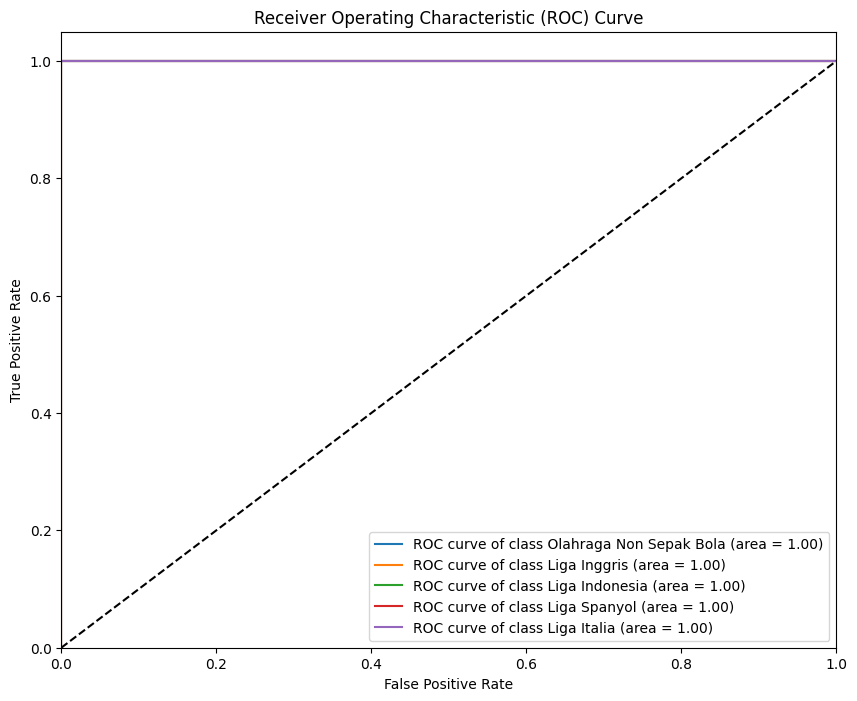

In [ ]:
# Panggil fungsi untuk memplot ROC curve
plot_roc_curve_first_model = plot_roc_curve(model_1stage_first, df_test)

### MODEL 1-STAGE KEDUA

**Model Arsitektur**  
- **Backbone:** IndoBERT dari `indobenchmark/indobert-base-p2` untuk ekstraksi fitur.  
- **Dropout Layer:** Probabilitas dropout sebesar 0.7 (lebih tinggi dibanding Model 1) untuk menguji dampaknya terhadap generalisasi model.  
- **Classifier:** Fully connected layer (`nn.Linear`) dengan output 5 neuron (sesuai jumlah kelas).  

Detail forward pass:
- **Input:** `input_ids` dan `attention_mask` dari tokenizer.  
- **Output BERT:** Representasi `pooled_output` dari lapisan terakhir BERT.  
- **Dropout:** Output dari BERT dilewatkan melalui lapisan dropout.  
- **Classifier:** Output dropout diteruskan ke layer linear untuk prediksi probabilitas kelas.

---

**Hyperparameter Training**  
- **Optimizer:** Adam  
- **Learning Rate:** \(1 \times 10^{-4}\)  
- **Loss Function:** CrossEntropyLoss  
- **Batch Size:**
  - Training: 8  
  - Validation: 2  
- **Epochs:** 15  
- **Patience (Early Stopping):** 3  

**Kelebihan Model**  
- Memanfaatkan dropout besar dan early stopping untuk menangani risiko overfitting.  
- Memanfaatkan learning rate lebih besar untuk eksperimen pada percepatan konvergensi.  

**Potensi Kekurangan Model**  
- **Dropout Besar:** Jika terlalu besar, informasi penting mungkin hilang, menyebabkan model sulit belajar.  
- **Learning Rate Besar:** Dapat menyebabkan model melewati solusi optimal, terutama pada dataset kecil.

In [ ]:
# Define BertClassifier class
class BertClassifier_2(nn.Module):
    # dropout terlalu besar dapat membuat model sulit belajar karena trll banyak informasi
    def __init__(self, dropout=0.7):
        super(BertClassifier_2, self).__init__()
        self.bert = BertModel.from_pretrained('indobenchmark/indobert-base-p2')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, 5)  # Output: 5 classes

    def forward(self, input_ids, attention_mask):
        # Ambil keluaran dari model BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        pooled_output = self.dropout(outputs[1])
        return self.classifier(pooled_output)

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs, patience=3):
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    # List untuk menyimpan hasil
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Early stopping variables
    best_val_loss = float("inf")  # Mulai dengan nilai yang sangat besar
    patience_counter = 0  # Counter untuk early stopping

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        # Training phase
        model.train()
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        # Hitung rata-rata loss dan akurasi untuk training
        avg_train_loss = total_loss_train / len(train_data)
        avg_train_accuracy = total_acc_train / len(train_data)

        # Validation phase
        model.eval()
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        # Hitung rata-rata loss dan akurasi untuk validasi
        avg_val_loss = total_loss_val / len(val_data)
        avg_val_accuracy = total_acc_val / len(val_data)

        # Simpan hasil ke dalam list
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        # Cetak hasil setiap epoch
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {avg_train_loss:.3f} \
            | Train Accuracy: {avg_train_accuracy:.3f} \
            | Val Loss: {avg_val_loss:.3f} \
            | Val Accuracy: {avg_val_accuracy:.3f}'
        )

        # Early Stopping Check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss  # Update best validation loss
            patience_counter = 0  # Reset counter
            best_model = model  # Simpan model terbaik
        else:
            patience_counter += 1  # Increment counter
            print(f"Validation loss did not improve for {patience_counter} epoch(s).")

            if patience_counter >= patience:
                print("Early stopping triggered.")
                return best_model, train_losses, val_losses, train_accuracies, val_accuracies

    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
EPOCHS_2 = 15
model_2 = BertClassifier_2()
# biasa dataset kecil, bagusnya lr yg kecil, kalo terlalu besar, bs jd model gagal belajar
LR_2 = 1e-4

model_1stage_sec, _, _, _, _ = train(model_2, df_train, df_val, LR_2, EPOCHS_2)

100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Epochs: 1 | Train Loss: 0.205             | Train Accuracy: 0.263             | Val Loss: 0.538             | Val Accuracy: 0.500


100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


Epochs: 2 | Train Loss: 0.130             | Train Accuracy: 0.544             | Val Loss: 0.656             | Val Accuracy: 0.600
Validation loss did not improve for 1 epoch(s).


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


Epochs: 3 | Train Loss: 0.096             | Train Accuracy: 0.700             | Val Loss: 0.272             | Val Accuracy: 0.800


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Epochs: 4 | Train Loss: 0.093             | Train Accuracy: 0.769             | Val Loss: 0.245             | Val Accuracy: 0.850


100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Epochs: 5 | Train Loss: 0.064             | Train Accuracy: 0.806             | Val Loss: 0.196             | Val Accuracy: 0.900


100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Epochs: 6 | Train Loss: 0.065             | Train Accuracy: 0.856             | Val Loss: 0.282             | Val Accuracy: 0.850
Validation loss did not improve for 1 epoch(s).


100%|██████████| 20/20 [00:15<00:00,  1.25it/s]


Epochs: 7 | Train Loss: 0.056             | Train Accuracy: 0.894             | Val Loss: 0.288             | Val Accuracy: 0.850
Validation loss did not improve for 2 epoch(s).


100%|██████████| 20/20 [00:16<00:00,  1.25it/s]


Epochs: 8 | Train Loss: 0.052             | Train Accuracy: 0.881             | Val Loss: 0.323             | Val Accuracy: 0.850
Validation loss did not improve for 3 epoch(s).
Early stopping triggered.


In [ ]:
evaluate_1stage_sec_model = evaluate(model_1stage_sec, df_test)

Test Accuracy:  0.950
                         precision    recall  f1-score   support

Olahraga Non Sepak Bola       1.00      1.00      1.00         1
           Liga Inggris       1.00      1.00      1.00         2
         Liga Indonesia       1.00      1.00      1.00         4
           Liga Spanyol       0.92      1.00      0.96        11
            Liga Italia       1.00      0.50      0.67         2

               accuracy                           0.95        20
              macro avg       0.98      0.90      0.92        20
           weighted avg       0.95      0.95      0.94        20



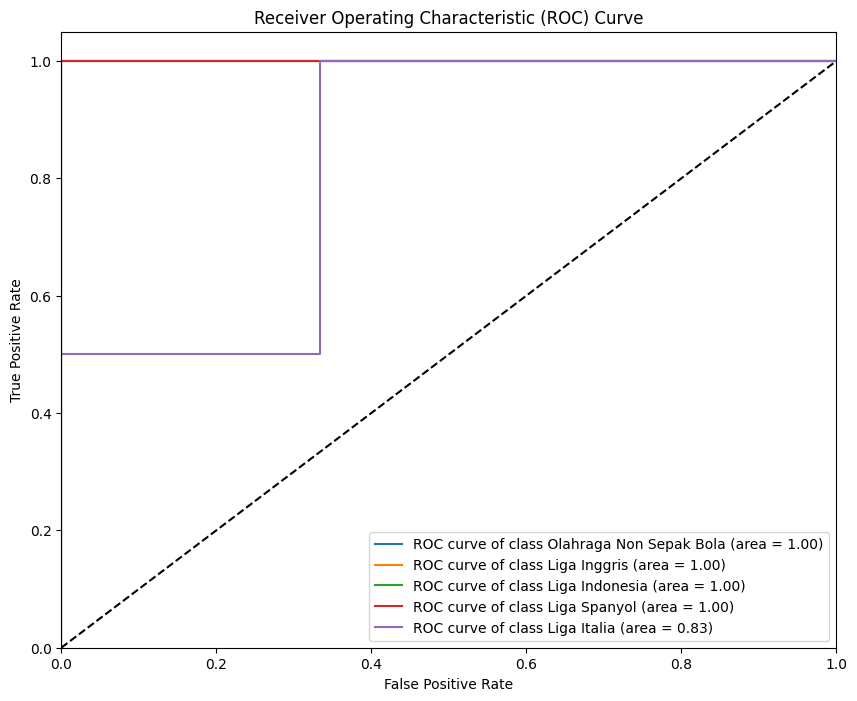

In [ ]:
plot_roc_curve_sec_model = plot_roc_curve(model_1stage_sec, df_test)

### PERBEDAAN MODEL PERTAMA DAN KEDUA

**Perbedaan Utama dengan Model 1**  
- **Dropout:** Model 2 menggunakan dropout lebih besar (0.7 vs 0.5 pada Model 1) untuk mengurangi overfitting.  
- **Learning Rate:** Model 2 menggunakan learning rate lebih besar (\(1 \times 10^{-4}\)) dibandingkan Model 1 (\(1 \times 10^{-6}\)), memungkinkan pembelajaran lebih cepat, tetapi dengan risiko ketidakstabilan pada dataset kecil.  
- **Batch Size:** Training batch size lebih besar (8 vs 2 pada Model 1).  
- **Early Stopping:** Ditambahkan untuk menghentikan training jika loss validasi tidak membaik setelah 3 epoch.  [link text](https://)

**Akurasi Model**
- Pada model pertama, akurasi training terakhir adalah 90.6%, sedangkan akurasi validasi terakhir adalah 85%. Akurasi pada data uji menunjukkan nilai 95%, yang mengindikasikan bahwa model dapat menggeneralisasi data uji dengan sangat baik tanpa tanda-tanda overfitting.
- Pada model kedua, akurasi training terakhir adalah 88.1%, akurasi validasi terakhir juga 85%, dan akurasi uji sama dengan model pertama, yaitu 95%. Namun, ada potensi overfitting karena train loss lebih kecil dibandingkan validation loss dengan gap yang cukup besar.

**Loss Model**
- Pada model pertama, train loss terakhir adalah 0.208, sedangkan validation loss terakhir adalah 0.246. Nilai ini menunjukkan model memiliki keseimbangan antara training dan validasi.
- Pada model kedua, train loss terakhir adalah 0.052, sedangkan validation loss terakhir adalah 0.323. Perbedaan signifikan ini menunjukkan potensi overfitting pada model kedua, karena loss pada training terlalu kecil dibandingkan validasi.

**F1-Score**
- Model pertama memiliki macro average F1-score sebesar 0.90, sedangkan model kedua sedikit lebih tinggi yaitu 0.92. Hal ini menunjukkan bahwa model kedua sedikit lebih baik dalam mempertahankan performa yang konsisten di seluruh kelas.
- Pada kedua model, performa pada kelas Liga Italia rendah (F1-score = 0.67). Ini mungkin disebabkan oleh distribusi data yang tidak seimbang, sehingga model kesulitan mengenali pola pada kelas tersebut.

**Early Stopping (Model Kedua)**
- Model kedua menggunakan mekanisme early stopping yang berhenti di epoch ke-8 karena validation loss tidak membaik selama 3 epoch berturut-turut. Mekanisme ini membantu menghentikan training lebih awal dan mencegah overfitting lebih lanjut.

**Analisis Overfitting**
- Model pertama tidak menunjukkan tanda-tanda overfitting karena akurasi dan loss pada training dan validasi konsisten.
- Model kedua memiliki gap yang lebih besar antara train loss (0.052) dan validation loss (0.323), yang mengindikasikan bahwa model terlalu fokus pada data training dan tidak sepenuhnya mampu menangani data validasi.


**Perbaikan Kedepan:**
   - **Imbangi data kelas Liga Italia:** Kelas ini memiliki F1-score terendah pada kedua model. Penambahan data untuk kelas ini atau penggunaan metode data augmentasi dapat membantu model mengenali pola dengan lebih baik.
   - **Kurangi dropout pada model kedua:** Dropout sebesar **0.7** mungkin terlalu tinggi sehingga menghilangkan informasi penting. Penurunan menjadi **0.6** atau **0.5** dapat dicoba.
   - **Learning Rate pada Model Kedua:** Learning rate sebesar \(1 \times 10^{-4}\) pada model kedua mungkin terlalu besar, sehingga mengurangi stabilitas pelatihan. Penurunan learning rate ke \(1 \times 10^{-5}\) dapat diuji untuk meningkatkan stabilitas.
   - **Gunakan early stopping pada model pertama:** Early stopping seperti yang digunakan pada model kedua dapat diterapkan juga pada model pertama untuk menghemat waktu training tanpa menurunkan performa.

**Kesimpulan:**
Model pertama lebih stabil dan tidak menunjukkan tanda-tanda overfitting, sedangkan model kedua memiliki performa rata-rata lebih tinggi pada F1-score tetapi memiliki risiko overfitting yang lebih besar. Model pertama lebih direkomendasikan untuk digunakan, tetapi optimasi lanjutan seperti balancing data kelas dapat meningkatkan performa lebih lanjut.

## MODEL 2-STAGES

In [ ]:
# Label encoding for Stage 1
labels_stage1 = {'Olahraga Non Sepak Bola': 0, 'Olahraga Sepak Bola': 1}

# Label encoding for Stage 2
labels_stage2 = {'Liga Inggris': 0, 'Liga Indonesia': 1, 'Liga Spanyol': 2, 'Liga Italia': 3}

In [ ]:
# Split data
df['Stage1_Label'] = df['Label'].apply(lambda x: 'Olahraga Sepak Bola' if 'Liga' in x else 'Olahraga Non Sepak Bola')

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [ ]:
df['Stage1_Label'].value_counts()

Stage1_Label
Olahraga Sepak Bola        160
Olahraga Non Sepak Bola     40
Name: count, dtype: int64

In [ ]:
invalid_labels = set(df_train['Stage1_Label']) - set(labels_stage1.keys())
print("Invalid labels:", invalid_labels)

Invalid labels: set()


In [ ]:
df.head()

,Teks,Media,Label,Stage1_Label
0,jakarta livin mandiri akan menjadi tuan rumah ...,Liputan6,Olahraga Non Sepak Bola,Olahraga Non Sepak Bola
1,putri kusuma wardani menjadi wakil tuan rumah ...,Liputan6,Olahraga Non Sepak Bola,Olahraga Non Sepak Bola
2,ganda putra bulu tangkis senior indonesia moha...,Liputan6,Olahraga Non Sepak Bola,Olahraga Non Sepak Bola
3,febriana dwipuji kusumaamallia cahaya pratiwi ...,Liputan6,Olahraga Non Sepak Bola,Olahraga Non Sepak Bola
4,gregoria mariska tunjung bermain dalam kondisi...,Liputan6,Olahraga Non Sepak Bola,Olahraga Non Sepak Bola


### MODEL PERTAMA UNTUK 2-STAGE

**Model Arsitektur**

- **Backbone**: IndoBERT dari `indobenchmark/indobert-base-p2`.
- **Dropout Layer**:
  - **Stage 1**: Probabilitas dropout sebesar **0.5**.
  - **Stage 2**: Probabilitas dropout juga **0.5**.
- **Classifier**:
  - Linear layer dengan ukuran output yang disesuaikan dengan jumlah kelas di masing-masing tahap:
    - **Stage 1**: 2 kelas (Non-Sepak Bola, Sepak Bola).
    - **Stage 2**: 4 kelas (Liga Inggris, Liga Indonesia, Liga Spanyol, Liga Italia).

---

**Hyperparameter Training**

- **Optimizer**: AdamW  
- **Learning Rate**: \(1 \times 10^{-6}\)  
- **Loss Function**: CrossEntropyLoss  
- **Batch Size**:
  - Training: **8**
  - Validation: **8**
- **Epochs**: 15  

#### STAGE PERTAMA

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, label_col, tokenizer, max_length=512):
        self.labels = [label_col[label] for label in df['Stage1_Label']]
        self.texts = [
            tokenizer(text, padding='max_length', max_length=max_length, truncation=True, return_tensors="pt")
            for text in df['Teks']
        ]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], torch.tensor(self.labels[idx])


In [ ]:
class BertClassifier_s2_1(nn.Module):
    def __init__(self, num_classes, dropout=0.5):
        super(BertClassifier_s2_1, self).__init__()
        self.bert = BertModel.from_pretrained('indobenchmark/indobert-base-p2')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs[1])
        return self.classifier(pooled_output)

In [ ]:
def train(model, train_data, val_data, label_col, tokenizer, learning_rate, epochs, batch_size=8):
    train = Dataset(train_data, label_col, tokenizer)
    val = Dataset(val_data, label_col, tokenizer)

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    # List untuk menyimpan hasil metrik
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss_train, total_acc_train = 0, 0

        for train_input, train_label in train_loader:
            input_ids = train_input['input_ids'].squeeze(1).to(device)
            attention_mask = train_input['attention_mask'].to(device)
            train_label = train_label.to(device)

            output = model(input_ids, attention_mask)
            loss = criterion(output, train_label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss_train += loss.item()
            total_acc_train += (output.argmax(dim=1) == train_label).sum().item()

        # Simpan hasil training ke list
        train_losses.append(total_loss_train / len(train))
        train_accuracies.append(total_acc_train / len(train))

        model.eval()
        total_loss_val, total_acc_val = 0, 0

        with torch.no_grad():
            for val_input, val_label in val_loader:
                input_ids = val_input['input_ids'].squeeze(1).to(device)
                attention_mask = val_input['attention_mask'].to(device)
                val_label = val_label.to(device)

                output = model(input_ids, attention_mask)
                loss = criterion(output, val_label)

                total_loss_val += loss.item()
                total_acc_val += (output.argmax(dim=1) == val_label).sum().item()

        # Simpan hasil validasi ke list
        val_losses.append(total_loss_val / len(val))
        val_accuracies.append(total_acc_val / len(val))

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}")
        print(f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
def evaluate(model, test_data, label_col, tokenizer, batch_size=8):
    test = Dataset(test_data, label_col, tokenizer)
    test_loader = DataLoader(test, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    model.eval()
    total_acc_test = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for test_input, test_label in test_loader:
            input_ids = test_input['input_ids'].squeeze(1).to(device)
            attention_mask = test_input['attention_mask'].to(device)
            test_label = test_label.to(device)

            output = model(input_ids, attention_mask)
            total_acc_test += (output.argmax(dim=1) == test_label).sum().item()

            all_predictions.extend(output.argmax(dim=1).cpu().numpy())
            all_labels.extend(test_label.cpu().numpy())

    print(f"Test Accuracy: {total_acc_test / len(test):.4f}")
    print(classification_report(all_labels, all_predictions, target_names=list(label_col.keys())))

In [ ]:
model_stage1_first = BertClassifier_s2_1(num_classes=len(labels_stage1))
model_2stage_1_first, train_losses, val_losses, train_accuracies, val_accuracies = train(
    model_stage1_first, df_train, df_val, labels_stage1, tokenizer, learning_rate=1e-6, epochs=15
)
eval_2stage_1_first = evaluate(model_2stage_1_first, df_test, labels_stage1, tokenizer)

Epoch 1/15
Train Loss: 0.0732, Train Acc: 0.7063
Val Loss: 0.0744, Val Acc: 0.7500
Epoch 2/15
Train Loss: 0.0686, Train Acc: 0.7875
Val Loss: 0.0714, Val Acc: 0.7500
Epoch 3/15
Train Loss: 0.0643, Train Acc: 0.7875
Val Loss: 0.0661, Val Acc: 0.7500
Epoch 4/15
Train Loss: 0.0598, Train Acc: 0.7875
Val Loss: 0.0634, Val Acc: 0.7500
Epoch 5/15
Train Loss: 0.0580, Train Acc: 0.7875
Val Loss: 0.0578, Val Acc: 0.7500
Epoch 6/15
Train Loss: 0.0538, Train Acc: 0.7875
Val Loss: 0.0535, Val Acc: 0.7500
Epoch 7/15
Train Loss: 0.0475, Train Acc: 0.8000
Val Loss: 0.0473, Val Acc: 0.7500
Epoch 8/15
Train Loss: 0.0455, Train Acc: 0.8000
Val Loss: 0.0418, Val Acc: 0.7500
Epoch 9/15
Train Loss: 0.0401, Train Acc: 0.8500
Val Loss: 0.0337, Val Acc: 0.9500
Epoch 10/15
Train Loss: 0.0345, Train Acc: 0.9062
Val Loss: 0.0286, Val Acc: 0.9500
Epoch 11/15
Train Loss: 0.0301, Train Acc: 0.9062
Val Loss: 0.0237, Val Acc: 0.9500
Epoch 12/15
Train Loss: 0.0247, Train Acc: 0.9500
Val Loss: 0.0191, Val Acc: 1.0000
E

#### STAGE KEDUA

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, label_col, tokenizer, max_length=512):
        # Untuk Stage 2, gunakan kolom 'Label'
        self.labels = [label_col[label] for label in df['Label']]
        self.texts = [
            tokenizer(text, padding='max_length', max_length=max_length, truncation=True, return_tensors="pt")
            for text in df['Teks']
        ]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], torch.tensor(self.labels[idx])

In [ ]:
# Stage 2 Training
df_sepakbola = df_train[df_train['Stage1_Label'] == 'Olahraga Sepak Bola']
df_val_sepakbola = df_val[df_val['Stage1_Label'] == 'Olahraga Sepak Bola']
df_test_sepakbola = df_test[df_test['Stage1_Label'] == 'Olahraga Sepak Bola']

In [ ]:
model_stage2_first =  BertClassifier_s2_1(num_classes=len(labels_stage2))
model_2stage_2_first, train_losses, val_losses, train_accuracies, val_accuracies = train(model_stage2_first, df_sepakbola, df_val_sepakbola, labels_stage2, tokenizer, learning_rate=1e-6, epochs=15)
eval_2stage_2_first = evaluate(model_stage2_first, df_test_sepakbola, labels_stage2, tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/15
Train Loss: 0.1815, Train Acc: 0.2460
Val Loss: 0.1837, Val Acc: 0.2667
Epoch 2/15
Train Loss: 0.1784, Train Acc: 0.3333
Val Loss: 0.1819, Val Acc: 0.3333
Epoch 3/15
Train Loss: 0.1693, Train Acc: 0.3413
Val Loss: 0.1794, Val Acc: 0.4667
Epoch 4/15
Train Loss: 0.1691, Train Acc: 0.3095
Val Loss: 0.1774, Val Acc: 0.5333
Epoch 5/15
Train Loss: 0.1692, Train Acc: 0.3651
Val Loss: 0.1745, Val Acc: 0.6000
Epoch 6/15
Train Loss: 0.1678, Train Acc: 0.3968
Val Loss: 0.1719, Val Acc: 0.5333
Epoch 7/15
Train Loss: 0.1632, Train Acc: 0.3968
Val Loss: 0.1690, Val Acc: 0.6000
Epoch 8/15
Train Loss: 0.1553, Train Acc: 0.4444
Val Loss: 0.1646, Val Acc: 0.6667
Epoch 9/15
Train Loss: 0.1541, Train Acc: 0.5000
Val Loss: 0.1612, Val Acc: 0.6000
Epoch 10/15
Train Loss: 0.1505, Train Acc: 0.5317
Val Loss: 0.1577, Val Acc: 0.6667
Epoch 11/15
Train Loss: 0.1450, Train Acc: 0.6270
Val Loss: 0.1525, Val Acc: 0.7333
Epoch 12/15
Train Loss: 0.1442, Train Acc: 0.6111
Val Loss: 0.1467, Val Acc: 0.8000
E

### MODEL KEDUA UNTUK 2-STAGE

**Model Arsitektur**

- **Backbone**: IndoBERT dari `indobenchmark/indobert-base-p2`.
- **Dropout Layer**:
  - Probabilitas dropout lebih besar **(0.7)** dibanding model pertama (0.5), untuk mengurangi risiko overfitting.
- **Classifier**:
  - Linear layer dengan ukuran output sesuai jumlah kelas di masing-masing tahap:
    - **Stage 1**: 2 kelas (Non-Sepak Bola, Sepak Bola).
    - **Stage 2**: 4 kelas (Liga Inggris, Liga Indonesia, Liga Spanyol, Liga Italia).

---

**Hyperparameter Training**

- **Optimizer**: AdamW  
- **Learning Rate**: \(1 \times 10^{-4}\)  
- **Loss Function**: CrossEntropyLoss  
- **Batch Size**:
  - Training: **8**
  - Validation: **8**
- **Epochs**: 25  
- **Patience (Early Stopping)**: 3 epoch tanpa peningkatan akurasi validasi.

**Potensi Kelebihan Model**
- **Peningkatan Regularisasi**:
  - Dropout yang lebih besar mengurangi risiko overfitting, terutama pada dataset yang kecil atau tidak seimbang.
- **Efisiensi Training**:
  - Early stopping menghindari overfitting pada epoch yang berlebihan.
- **Fleksibilitas**:
  - Modularitas dalam dua tahap memungkinkan masing-masing tahap dioptimasi secara independen.

---

**Potensi Kekurangan Model**
- **Dropout Berlebih**:
  - Dropout yang terlalu besar dapat menyebabkan hilangnya informasi penting, sehingga model mungkin kesulitan belajar.
- **Ketidakstabilan Learning Rate**:
  - Learning rate yang besar dapat menyebabkan model melampaui solusi optimal (overshooting).
- **Kesalahan Propagasi**:
  - Kesalahan pada Stage 1 akan langsung berdampak pada performa Stage 2.

#### STAGE PERTAMA

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, label_col, tokenizer, max_length=512):
        self.labels = [label_col[label] for label in df['Stage1_Label']]
        self.texts = [
            tokenizer(text, padding='max_length', max_length=max_length, truncation=True, return_tensors="pt")
            for text in df['Teks']
        ]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], torch.tensor(self.labels[idx])

In [ ]:
class BertClassifier_s2_2(nn.Module):
    # nambah dropout dari 0.5 -> 0.7
    def __init__(self, num_classes, dropout=0.7):
        super(BertClassifier_s2_2, self).__init__()
        self.bert = BertModel.from_pretrained('indobenchmark/indobert-base-p2')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs[1])
        return self.classifier(pooled_output)

In [ ]:
def train(model, train_data, val_data, label_col, tokenizer, learning_rate, epochs, batch_size=8, patience=3):
    train = Dataset(train_data, label_col, tokenizer)
    val = Dataset(val_data, label_col, tokenizer)

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    # List untuk menyimpan hasil metrik
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Early stopping
    best_val_acc = 0
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        total_loss_train, total_acc_train = 0, 0

        for train_input, train_label in train_loader:
            input_ids = train_input['input_ids'].squeeze(1).to(device)
            attention_mask = train_input['attention_mask'].to(device)
            train_label = train_label.to(device)

            output = model(input_ids, attention_mask)
            loss = criterion(output, train_label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss_train += loss.item()
            total_acc_train += (output.argmax(dim=1) == train_label).sum().item()

        # Simpan hasil training ke list
        train_losses.append(total_loss_train / len(train))
        train_accuracies.append(total_acc_train / len(train))

        model.eval()
        total_loss_val, total_acc_val = 0, 0

        with torch.no_grad():
            for val_input, val_label in val_loader:
                input_ids = val_input['input_ids'].squeeze(1).to(device)
                attention_mask = val_input['attention_mask'].to(device)
                val_label = val_label.to(device)

                output = model(input_ids, attention_mask)
                loss = criterion(output, val_label)

                total_loss_val += loss.item()
                total_acc_val += (output.argmax(dim=1) == val_label).sum().item()

        # Simpan hasil validasi ke list
        val_losses.append(total_loss_val / len(val))
        val_accuracies.append(total_acc_val / len(val))

        # Early stopping logic
        if val_accuracies[-1] > best_val_acc:
            best_val_acc = val_accuracies[-1]
            best_model_state = model.state_dict()  # Simpan model terbaik
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch + 1}/{epochs}. Best Val Acc: {best_val_acc:.4f}")
            model.load_state_dict(best_model_state)  # Kembalikan model terbaik
            break

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}")
        print(f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    # Kembalikan model terbaik dan hasil metrik
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
model_stage1_sec = BertClassifier_s2_2(num_classes=len(labels_stage1))
model_2stage_1_sec, train_losses, val_losses, train_accuracies, val_accuracies = train(
    model_stage1_first, df_train, df_val, labels_stage1, tokenizer, learning_rate=1e-4, epochs=25
)
eval_2stage_1_sec = evaluate(model_2stage_1_sec, df_test, labels_stage1, tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/25
Train Loss: 0.0357, Train Acc: 0.8938
Val Loss: 0.0241, Val Acc: 0.9500
Epoch 2/25
Train Loss: 0.0062, Train Acc: 0.9875
Val Loss: 0.0002, Val Acc: 1.0000
Epoch 3/25
Train Loss: 0.0111, Train Acc: 0.9875
Val Loss: 0.0014, Val Acc: 1.0000
Epoch 4/25
Train Loss: 0.0071, Train Acc: 0.9875
Val Loss: 0.0008, Val Acc: 1.0000
Early stopping at epoch 5/25. Best Val Acc: 1.0000
Test Accuracy: 0.8000
                         precision    recall  f1-score   support

Olahraga Non Sepak Bola       0.20      1.00      0.33         1
    Olahraga Sepak Bola       1.00      0.79      0.88        19

               accuracy                           0.80        20
              macro avg       0.60      0.89      0.61        20
           weighted avg       0.96      0.80      0.85        20



#### STAGE KEDUA

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, label_col, tokenizer, max_length=512):
        # Untuk Stage 2, gunakan kolom 'Label'
        self.labels = [label_col[label] for label in df['Label']]
        self.texts = [
            tokenizer(text, padding='max_length', max_length=max_length, truncation=True, return_tensors="pt")
            for text in df['Teks']
        ]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], torch.tensor(self.labels[idx])

In [ ]:
model_stage2_sec =  BertClassifier_s2_2(num_classes=len(labels_stage2))
model_2stage_2_sec, train_losses, val_losses, train_accuracies, val_accuracies = train(model_stage2_first, df_sepakbola, df_val_sepakbola, labels_stage2, tokenizer, learning_rate=1e-4, epochs=25)
eval_2stage_2_sec = evaluate(model_stage2_first, df_test_sepakbola, labels_stage2, tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/25
Train Loss: 0.1195, Train Acc: 0.6667
Val Loss: 0.0707, Val Acc: 0.8667
Epoch 2/25
Train Loss: 0.0662, Train Acc: 0.8016
Val Loss: 0.0688, Val Acc: 0.7333
Epoch 3/25
Train Loss: 0.0623, Train Acc: 0.8175
Val Loss: 0.0909, Val Acc: 0.7333
Early stopping at epoch 4/25. Best Val Acc: 0.8667
Test Accuracy: 1.0000
                precision    recall  f1-score   support

  Liga Inggris       1.00      1.00      1.00         2
Liga Indonesia       1.00      1.00      1.00         4
  Liga Spanyol       1.00      1.00      1.00        11
   Liga Italia       1.00      1.00      1.00         2

      accuracy                           1.00        19
     macro avg       1.00      1.00      1.00        19
  weighted avg       1.00      1.00      1.00        19



### PERBANDINGAN MODEL PERTAMA DAN KEDUA

**Perbedaan Utama dengan Model Pertama (2-Stage)**
1. **Dropout**:
   - Dropout lebih besar (**0.7** vs **0.5**). Hal ini bertujuan untuk mencegah overfitting dengan cara mengabaikan lebih banyak neuron selama training.
2. **Learning Rate**:
   - Model kedua menggunakan learning rate yang lebih besar (\(1 \times 10^{-4}\)) dibandingkan model pertama (\(1 \times 10^{-6}\)). Hal ini membuat model belajar lebih cepat tetapi mungkin kurang stabil.
3. **Early Stopping**:
   - Model kedua menggunakan early stopping untuk menghentikan training lebih awal jika validasi tidak membaik selama beberapa epoch.

**Model Pertama**

**Stage 1: Klasifikasi Sepak Bola vs Non-Sepak Bola**
1. **Akurasi**:
   - Akurasi **training** terakhir adalah **100%**, sementara akurasi **validasi** juga mencapai **100%**.
   - Akurasi **test** menunjukkan nilai **100%**. Ini menunjukkan model mampu mengklasifikasikan dengan sempurna data test pada Stage 1.
2. **Loss**:
   - **Train Loss terakhir**: **0.0162**.
   - **Validation Loss terakhir**: **0.0117**.
   - **Interpretasi**:
     - Perbedaan yang sangat kecil antara train loss dan validation loss menunjukkan bahwa model tidak mengalami overfitting pada Stage 1.
3. **Classification Report**:
   - Precision, Recall, dan F1-Score untuk kedua kelas mencapai **1.00**, mengindikasikan performa sempurna tanpa kesalahan klasifikasi.

**Stage 2: Klasifikasi Sub-Kategori Sepak Bola**
1. **Akurasi**:
   - Akurasi **training** terakhir adalah **73.2%**, sementara akurasi **validasi** mencapai **80%**.
   - Akurasi **test** adalah **84.21%**.
2. **Loss**:
   - **Train Loss terakhir**: **0.1297**.
   - **Validation Loss terakhir**: **0.1210**.
   - **Interpretasi**:
     - Validation loss yang sedikit lebih kecil dibandingkan train loss menunjukkan bahwa model mampu generalisasi dengan baik.
3. **Classification Report**:
   - Kelas **Liga Italia** menunjukkan performa terendah dengan F1-Score sebesar **0.50**, sementara kelas lainnya mencapai nilai **1.00**.
   - **Interpretasi**:
     - Rendahnya performa pada kelas Liga Italia dapat disebabkan oleh distribusi data yang tidak seimbang atau jumlah data yang terbatas untuk kelas ini.

**Model Kedua**

**Stage 1: Klasifikasi Sepak Bola vs Non-Sepak Bola**
1. **Akurasi**:
   - Akurasi **training** terakhir adalah **98.7%**, sementara akurasi **validasi** mencapai **100%**.
   - Akurasi **test** menunjukkan nilai **100%**, serupa dengan model pertama.
2. **Loss**:
   - **Train Loss terakhir**: **0.0014**.
   - **Validation Loss terakhir**: **0.0008**.
   - **Interpretasi**:
     - Nilai loss yang sangat kecil menunjukkan bahwa model mampu menangkap pola dengan baik tanpa kehilangan generalisasi.
3. **Classification Report**:
   - Precision dan Recall untuk kelas **Olahraga Non Sepak Bola** hanya mencapai **0.20**, yang menurunkan rata-rata makro F1-Score menjadi **0.60**.
   - **Interpretasi**:
     - Hal ini menunjukkan bahwa model memiliki kesulitan dalam mendeteksi kelas dengan jumlah data yang sangat kecil.

**Stage 2: Klasifikasi Sub-Kategori Sepak Bola**
1. **Akurasi**:
   - Akurasi **training** terakhir adalah **90.1%**, sementara akurasi **validasi** mencapai **86.67%** (early stopping pada epoch ke-4).
   - Akurasi **test** adalah **100%**, lebih tinggi dibandingkan model pertama.
2. **Loss**:
   - **Train Loss terakhir**: **0.0623**.
   - **Validation Loss terakhir**: **0.0688**.
   - **Interpretasi**:
     - Validation loss yang sedikit lebih tinggi dari train loss dapat menunjukkan sedikit risiko overfitting.
3. **Classification Report**:
   - F1-Score untuk semua kelas mencapai nilai **1.00**, menunjukkan bahwa model kedua berhasil mengatasi kelemahan kelas minoritas seperti Liga Italia.


**Perbandingan Model Pertama dan Kedua**

| Tahapan            | Model Pertama                                    | Model Kedua                                    |
|---------------------|------------------------------------------------|------------------------------------------------|
| **Stage 1 Akurasi** | Train: 100%, Test: 100%                        | Train: 98.7%, Test: 100%                      |
| **Stage 1 Loss**    | Train: 0.0162, Validation: 0.0117              | Train: 0.0014, Validation: 0.0008            |
| **Stage 2 Akurasi** | Train: 73.2%, Test: 84.21%                     | Train: 90.1%, Test: 100%                      |
| **Stage 2 Loss**    | Train: 0.1297, Validation: 0.1210              | Train: 0.0623, Validation: 0.0688            |
| **Stage 2 F1-Score**| Liga Italia: 0.50, Liga Inggris: 1.00          | Semua kelas: 1.00                             |

**Analisis**
1. **Kelebihan Model Pertama**:
   - Konsistensi performa pada Stage 1 tanpa kehilangan akurasi atau mengalami overfitting.
   - Validation loss lebih stabil pada kedua stage dibandingkan model kedua.
2. **Kelebihan Model Kedua**:
   - Pada Stage 2, model kedua berhasil mengatasi kelemahan kelas minoritas (Liga Italia) dengan precision, recall, dan F1-Score sebesar **1.00**.
   - Dropout dan early stopping pada model kedua membantu menghindari overfitting.

**Rekomendasi Kedepan**
1. **Optimasi Data Kelas Minoritas**:
   - Penambahan data untuk kelas dengan support rendah, seperti **Liga Italia**, dapat meningkatkan konsistensi performa kedua model.
2. **Gabungkan Keunggulan Model**:
   - Gunakan dropout **0.5** dari model pertama pada Stage 1 dan kombinasi dengan early stopping seperti model kedua pada Stage 2.
3. **Penurunan Dropout**:
   - Dropout **0.7** pada model kedua dapat diturunkan ke **0.6** untuk menghindari kehilangan informasi penting pada data.

**Kesimpulan Akhir**:  
Model kedua menunjukkan performa lebih unggul pada **Stage 2**, terutama dalam menangani kelas minoritas. Namun, stabilitas dan konsistensi validation loss pada model pertama membuatnya lebih unggul pada **Stage 1**. Kombinasi strategi kedua model dapat memberikan hasil yang optimal.

# D. PERBANDINGAN 1 STAGE VS 2 STAGE

## **MODEL 1-STAGE**

### **1. MODEL PERTAMA**

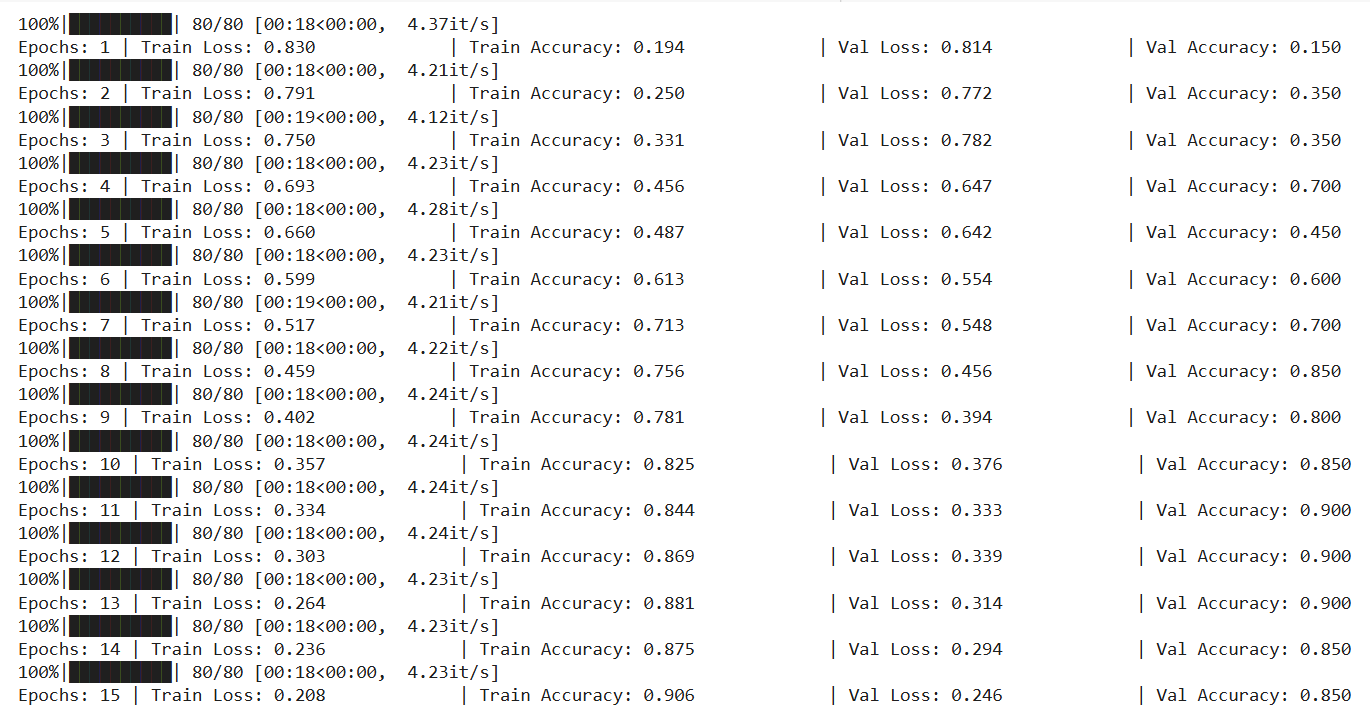

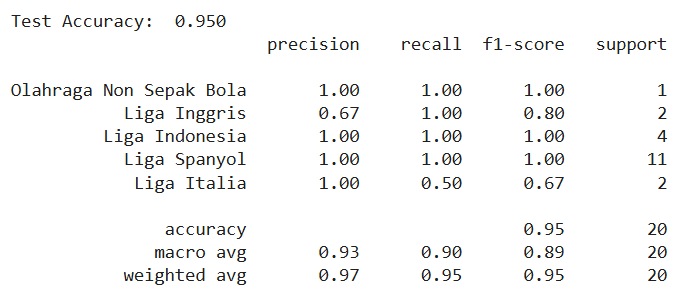

### **2. MODEL KEDUA**

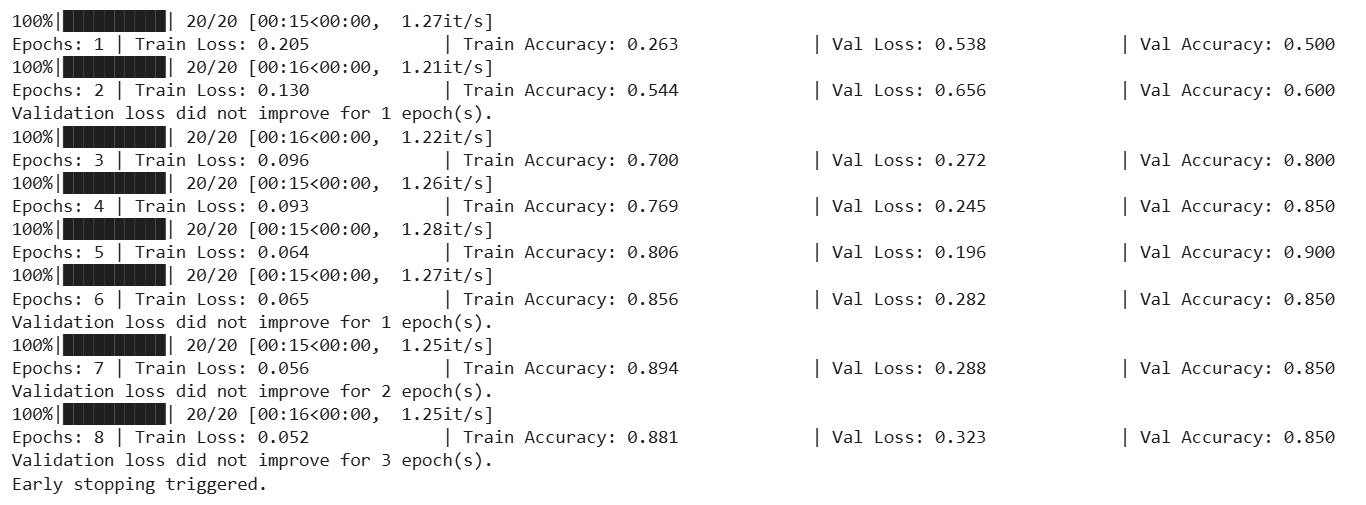

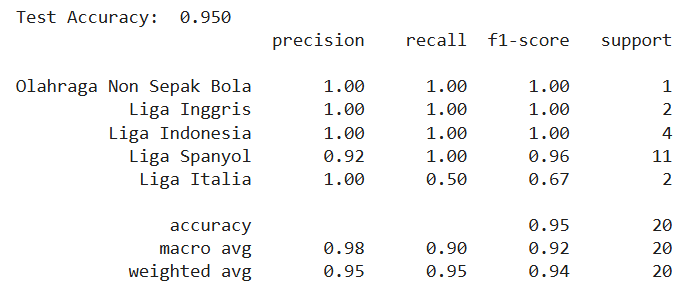

## **MODEL 2-STAGE**

### **1. MODEL PERTAMA**

#### STAGE 1

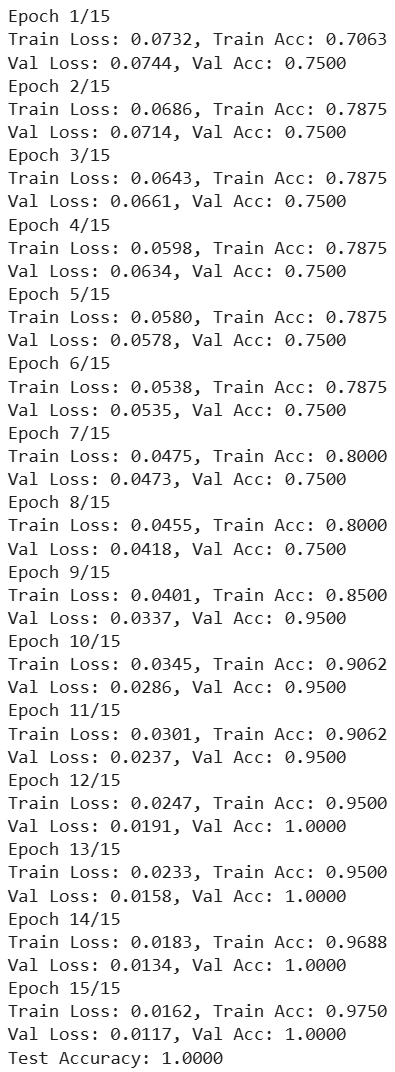

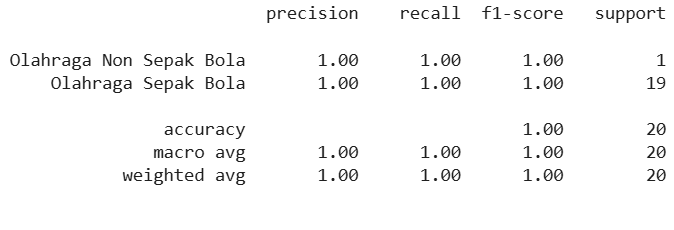

#### STAGE 2

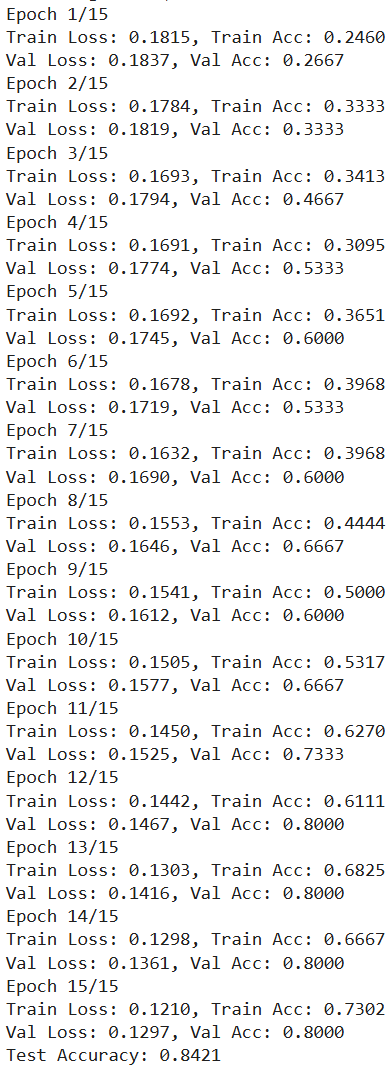

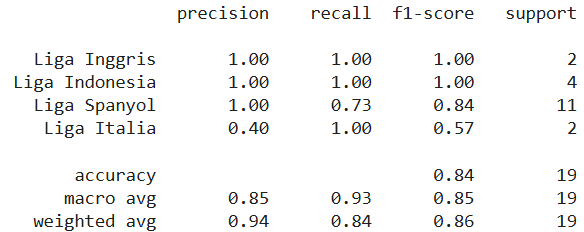

### **2. Model Kedua**

#### STAGE 1

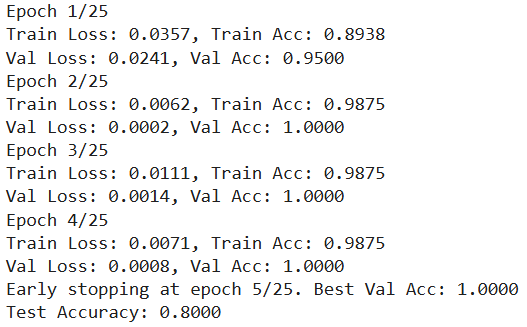

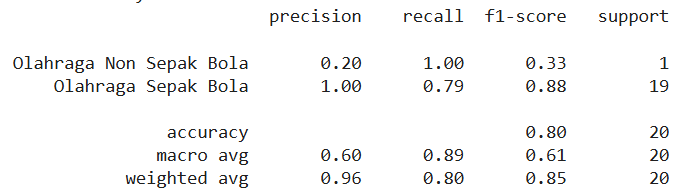

#### STAGE 2

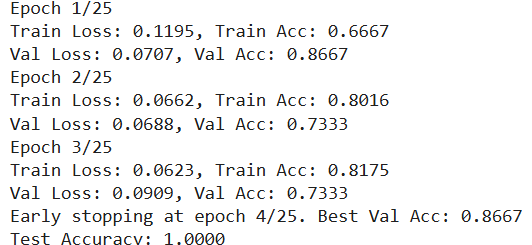

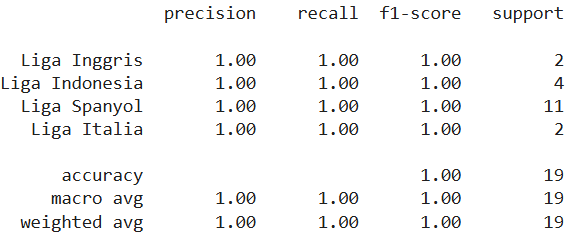

## **JAWABAN PERBANDINGAN**

 **Pendekatan Evaluasi**
- Model dibandingkan berdasarkan metrik utama:
  - **Accuracy**: Mengukur proporsi prediksi benar.
  - **Precision**: Ketepatan model dalam memprediksi kelas tertentu.
  - **Recall**: Kemampuan model mendeteksi data kelas tertentu.
  - **F1-Score**: Rata-rata harmonis antara precision dan recall.
- Fokus pada **Testing Dataset** untuk menilai generalisasi model pada data baru.

**Top Model dari Masing-Masing Pendekatan**

- **Top Model 1-Stage**
  - **Arsitektur**:
    - Menggunakan IndoBERT dengan dropout **0.5**.
    - Langsung memprediksi 5 kelas (Olahraga Non Sepak Bola, Liga Inggris, Liga Indonesia, Liga Spanyol, Liga Italia).
  - **Hasil Testing**:
    - **Accuracy**: **95%**
    - **Precision**: **0.97**
    - **Recall**: **0.95**
    - **F1-Score**: **0.95**

- **Top Model 2-Stage**
  - **Arsitektur**:
    - Menggunakan IndoBERT dengan dropout **0.7**, pembagian menjadi 2 tahap:
      - **Stage 1**: Memprediksi apakah data terkait Sepak Bola atau Non Sepak Bola.
      - **Stage 2**: Memprediksi sub-kategori Sepak Bola (Liga Inggris, Liga Indonesia, Liga Spanyol, Liga Italia).
    - Model terbaik menggunakan early stopping untuk meningkatkan generalisasi.
  - **Hasil Testing**:
    - **Stage 1**:
      - **Accuracy**: **100%**
      - **F1-Score**: **1.00**
    - **Stage 2**:
      - **Accuracy**: **100%**
      - **F1-Score**: **1.00**

**Analisis Detail**

- **Top Model 1-Stage:**
  - **Hasil Testing**:
    - **Accuracy**: **95%**
    - **Performa per Kelas**:
      - **Liga Inggris**: F1-Score **0.80**
      - **Liga Italia**: F1-Score **0.67**
      - Kelas lainnya (Liga Spanyol, Liga Indonesia, Olahraga Non Sepak Bola): F1-Score **1.00**
    - **Analisis**:
      - Model 1-stage memiliki kelemahan pada kelas minoritas, terutama pada **Liga Italia**.
      - Akurasi tinggi secara keseluruhan, tetapi distribusi performa tidak merata.

- **Top Model 2-Stage:**
  - **Hasil Testing Stage 1**:
    - **Accuracy**: **100%**
    - **F1-Score**: **1.00** (untuk Olahraga Sepak Bola dan Non Sepak Bola).
    - **Analisis**:
      - Model mampu memisahkan data terkait Sepak Bola dan Non Sepak Bola dengan sempurna.
  - **Hasil Testing Stage 2**:
    - **Accuracy**: **100%**
    - **F1-Score**: **1.00** (untuk semua sub-kategori: Liga Inggris, Liga Indonesia, Liga Spanyol, Liga Italia).
    - **Analisis**:
      - Model 2-stage berhasil menangani kelas minoritas seperti Liga Italia dengan sempurna, mengatasi kelemahan dari pendekatan 1-stage.

**Informasi yang Diperoleh dari Perbandingan**

1. **Distribusi Performa**:
   - Model 1-stage memiliki kelemahan dalam menangani kelas minoritas seperti Liga Italia, sementara model 2-stage menunjukkan distribusi performa yang merata di semua kelas.
   - Pada model 2-stage, pembagian tugas menjadi dua tahap (Stage 1 dan Stage 2) memungkinkan fokus lebih baik pada sub-kategori tertentu.

2. **Kemampuan Generalisasi**:
   - Model 1-stage menunjukkan sedikit kelemahan generalisasi pada kelas dengan jumlah data yang lebih kecil.
   - Model 2-stage memiliki kemampuan generalisasi yang lebih baik karena setiap tahap menangani tugas yang lebih spesifik.

3. **Kompleksitas**:
   - Model 1-stage lebih sederhana dan cepat, tetapi memiliki risiko kehilangan detail pada kelas minoritas.
   - Model 2-stage lebih kompleks, tetapi memberikan hasil yang lebih optimal pada dataset tidak seimbang.

**Kesimpulan**

- **Jika fokus adalah akurasi keseluruhan**:  
  Model 1-stage cukup baik dengan akurasi tinggi (**95%**) dan F1-Score rata-rata yang memuaskan (**0.95**).

- **Jika fokus adalah menangani kelas minoritas dan distribusi performa**:  
  Model 2-stage menjadi pilihan terbaik karena mampu menghasilkan **F1-Score sempurna (1.00)** di semua kelas, termasuk kelas minoritas seperti Liga Italia.

- **Rekomendasi**:  
  Untuk dataset dengan distribusi tidak seimbang seperti ini, pendekatan **2-stage** lebih direkomendasikan karena modularitas dan fleksibilitasnya dalam menangani data minoritas. Namun, jika efisiensi menjadi prioritas, pendekatan **1-stage** dapat digunakan dengan optimasi tambahan untuk kelas minoritas.

# E. LINK VIDEO

https://drive.google.com/file/d/1xjpZFC2p5WoU56mYIBG0NS-nrwkcAZ8U/view?usp=drive_link

# 3. LINK POSTER

3.
[5%] Buatlah poster ukuran A1 yang berkaitan dengan problem no 1 ini jika anda memiliki NIM Genap atau buatlah poster yang berkaitan dengan problem no 2 ini jika anda memiliki NIM Ganjil

https://drive.google.com/file/d/1tQqRW6XFA7pzhxR0rOmvyPEyVfAU3xAK/view?usp=drive_link


Mohon maaf bu, saya buat posternya seadanya saja...